In [549]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [178]:
data = pd.read_csv("retail_store_inventory.csv")

In [179]:
df = data.copy()

In [180]:
df.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [181]:
df.tail()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring
73099,2024-01-01,S005,P0020,Groceries,East,117,6,165,2.33,78.39,20,Rainy,1,79.52,Spring


# EDA

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [183]:
df.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [184]:
df.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [185]:
df.shape

(73100, 15)

In [186]:
df['Store ID'].nunique()

5

In [187]:
df['Category'].nunique()

5

In [188]:
df.groupby('Category').agg({
    'Units Sold': ['mean', 'std', 'sum', 'count'],
    'Price': 'mean',
    'Discount': 'mean'
}).round(2)

Units Sold                          Price Discount
                  mean     std      sum  count   mean     mean
Category                                                      
Clothing        136.69  108.42  1999166  14626  54.89    10.01
Electronics     135.01  108.45  1960432  14521  55.31    10.04
Furniture       137.77  110.02  2025017  14699  55.18    10.03
Groceries       136.92  109.26  2000482  14611  55.27     9.98
Toys            135.93  108.43  1990485  14643  55.03     9.99

# Visualizations

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Groceries'),
  Text(1, 0, 'Toys'),
  Text(2, 0, 'Electronics'),
  Text(3, 0, 'Furniture'),
  Text(4, 0, 'Clothing')])

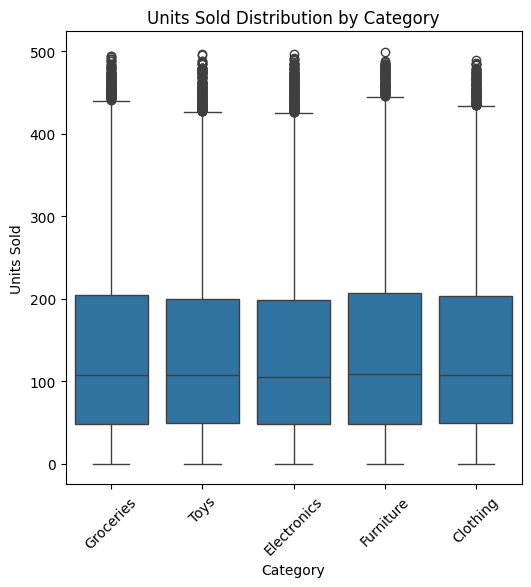

In [198]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
sns.boxplot(data=df, x='Category', y='Units Sold')
plt.title('Units Sold Distribution by Category')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Average Units Sold by Store')

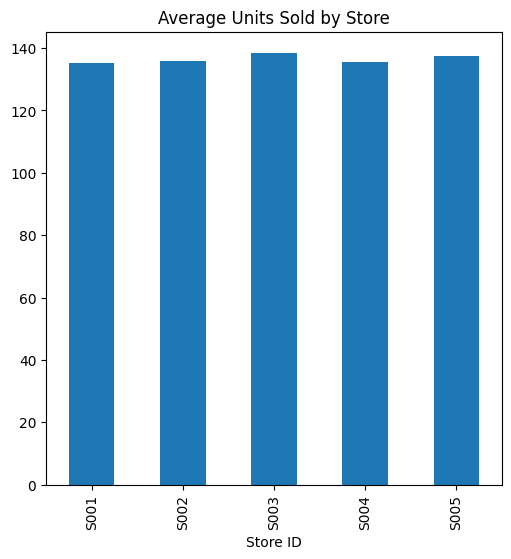

In [199]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 2)
store_sales = df.groupby('Store ID')['Units Sold'].mean()
store_sales.plot(kind='bar')
plt.title('Average Units Sold by Store')

Text(0.5, 1.0, 'Daily Sales Trend')

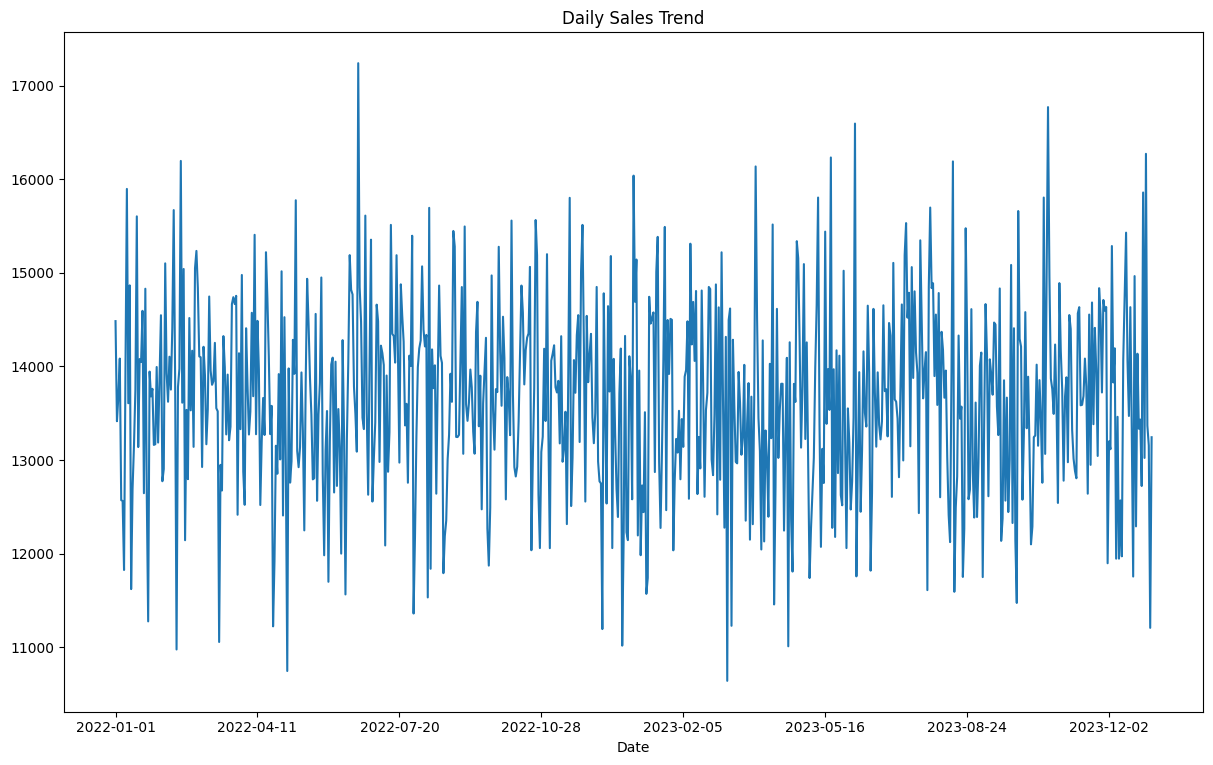

In [200]:
plt.figure(figsize=(50, 30))
plt.subplot(3, 3, 3)
daily_sales = df.groupby('Date')['Units Sold'].sum()
daily_sales.plot()
plt.title('Daily Sales Trend')

Text(0.5, 1.0, 'Average Sales: Store vs Category')

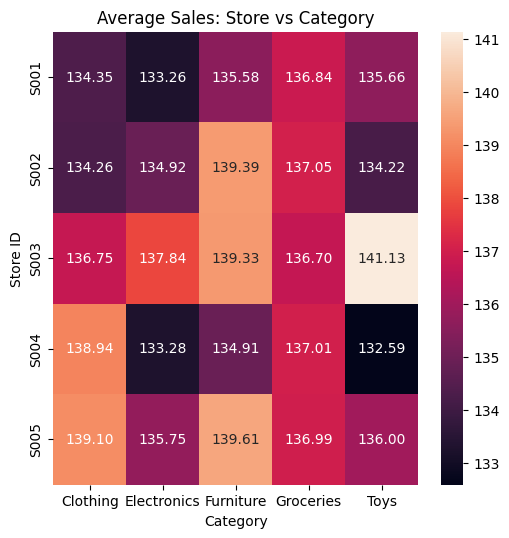

In [201]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 4)
category_store = df.groupby(['Store ID', 'Category'])['Units Sold'].mean().unstack()
sns.heatmap(category_store, annot=True, fmt='.2f')
plt.title('Average Sales: Store vs Category')

Text(0.5, 1.0, 'Price vs Units Sold')

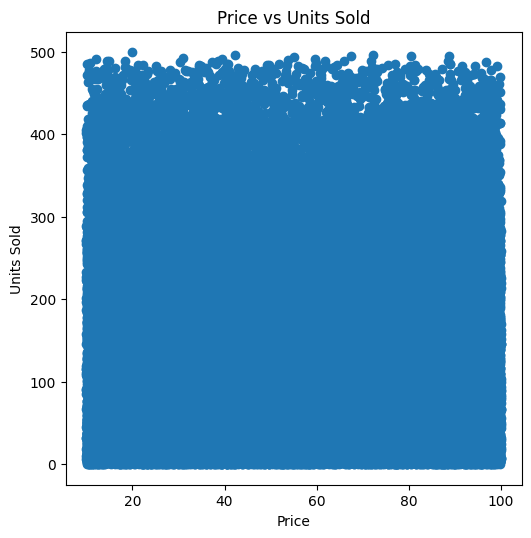

In [202]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 5)
plt.scatter(df['Price'], df['Units Sold'])
plt.xlabel('Price')
plt.ylabel('Units Sold')
plt.title('Price vs Units Sold')

Text(0.5, 1.0, 'Weather Impact on Sales')

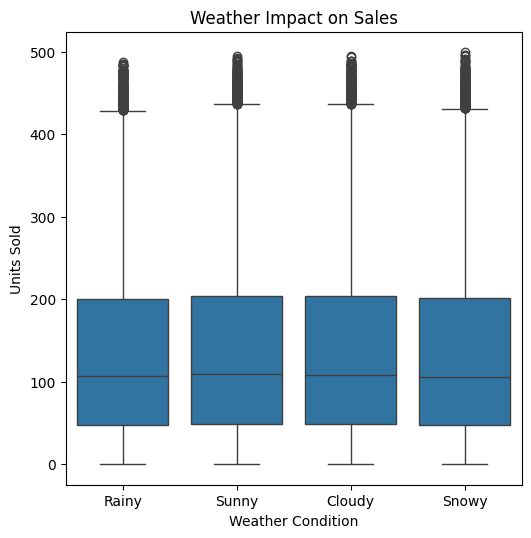

In [203]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 6)
sns.boxplot(data=df, x='Weather Condition', y='Units Sold')
plt.title('Weather Impact on Sales')

Text(0.5, 1.0, 'Seasonal Sales Pattern')

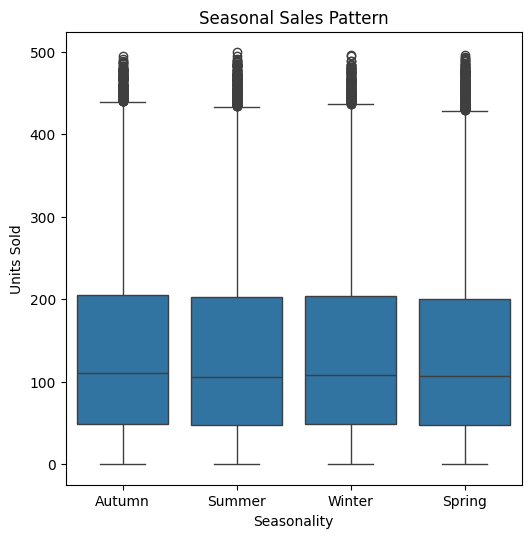

In [204]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 7)
sns.boxplot(data=df, x='Seasonality', y='Units Sold')
plt.title('Seasonal Sales Pattern')

Text(0.5, 1.0, 'Holiday/Promotion Effect')

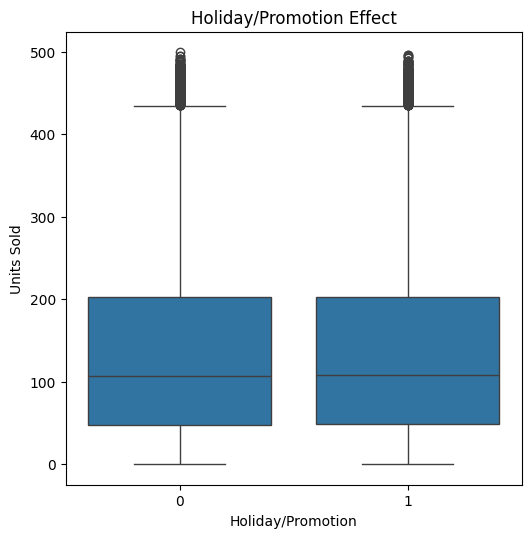

In [205]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 8)
sns.boxplot(data=df, x='Holiday/Promotion', y='Units Sold')
plt.title('Holiday/Promotion Effect')

Text(0.5, 1.0, 'Feature Correlation Heatmap')

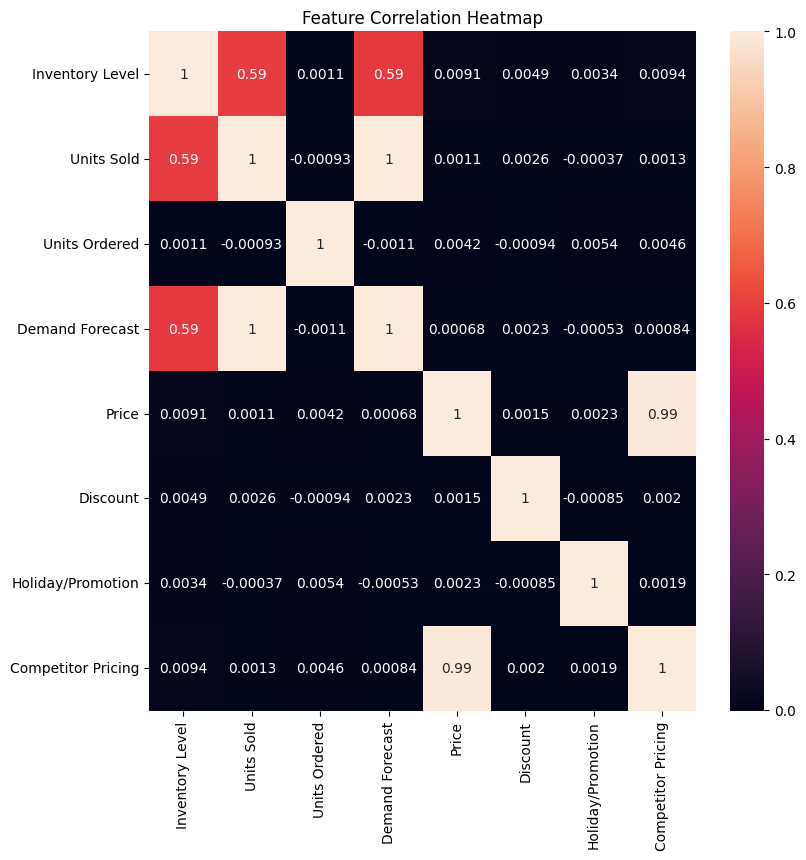

In [206]:
plt.figure(figsize=(30, 30))
plt.subplot(3, 3, 9)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Feature Correlation Heatmap')

In [207]:
df.drop(columns=['Demand Forecast'], axis=1, inplace=True)

In [208]:
df

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,53.14,20,Rainy,0,55.80,Spring


# Data Preprocessing

In [209]:
df['Date'] = pd.to_datetime(df['Date'])

In [210]:
df = df.sort_values(['Date', 'Store ID', 'Category']).reset_index(drop=True)

In [211]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

In [212]:
categorical_columns = ['Store ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
label_encoders = {}

In [213]:
for col in categorical_columns:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [214]:
def lag_features(group_df, target_col='Units Sold', windows=[3, 7, 14, 30]):
    group_df = group_df.sort_values('Date').copy()
    for window in windows:
        group_df[f'{target_col}_rolling_mean_{window}d'] = (
            group_df[target_col].rolling(window=window, min_periods=1).mean()
        )
        group_df[f'{target_col}_rolling_std_{window}d'] = (
            group_df[target_col].rolling(window=window, min_periods=1).std().fillna(0)
        )
        group_df[f'{target_col}_rolling_max_{window}d'] = (
            group_df[target_col].rolling(window=window, min_periods=1).max()
        )
        group_df[f'{target_col}_rolling_min_{window}d'] = (
            group_df[target_col].rolling(window=window, min_periods=1).min()
        )
    for lag in [1, 3, 7, 14]:
        group_df[f'{target_col}_lag_{lag}d'] = group_df[target_col].shift(lag)
    return group_df

In [215]:
df_processed = df.groupby(['Store ID', 'Category']).apply(lag_features).reset_index(drop=True)

C:\Users\spase\AppData\Local\Temp\ipykernel_2328\2770222277.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = df.groupby(['Store ID', 'Category']).apply(lag_features).reset_index(drop=True)


In [216]:
df_processed

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Units Sold_rolling_max_14d,Units Sold_rolling_min_14d,Units Sold_rolling_mean_30d,Units Sold_rolling_std_30d,Units Sold_rolling_max_30d,Units Sold_rolling_min_30d,Units Sold_lag_1d,Units Sold_lag_3d,Units Sold_lag_7d,Units Sold_lag_14d
0,2022-01-01,S001,P0008,Clothing,North,380,312,54,97.99,5,...,312.0,312.0,312.000000,0.000000,312.0,312.0,NaN,NaN,NaN,NaN
1,2022-01-01,S001,P0012,Clothing,West,66,24,70,58.25,20,...,312.0,24.0,168.000000,203.646753,312.0,24.0,312.0,NaN,NaN,NaN
2,2022-01-01,S001,P0014,Clothing,West,193,12,187,78.11,0,...,312.0,12.0,116.000000,169.846990,312.0,12.0,24.0,NaN,NaN,NaN
3,2022-01-01,S001,P0015,Clothing,North,379,369,154,92.99,15,...,369.0,12.0,179.250000,187.707885,369.0,12.0,12.0,312.0,NaN,NaN
4,2022-01-01,S001,P0018,Clothing,South,241,151,47,19.57,5,...,369.0,12.0,173.600000,163.049992,369.0,12.0,369.0,24.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0017,Toys,North,313,51,101,82.57,10,...,299.0,6.0,126.400000,98.010766,352.0,6.0,184.0,17.0,6.0,29.0
73096,2024-01-01,S005,P0004,Toys,North,158,85,193,77.29,10,...,299.0,6.0,126.866667,97.770926,352.0,6.0,51.0,190.0,271.0,11.0
73097,2024-01-01,S005,P0001,Toys,North,300,201,69,99.33,10,...,299.0,6.0,133.033333,96.361204,352.0,6.0,85.0,184.0,299.0,46.0
73098,2024-01-01,S005,P0005,Toys,South,372,154,143,96.72,0,...,299.0,6.0,126.433333,87.190906,299.0,6.0,201.0,51.0,160.0,153.0


In [217]:
lag_columns = [col for col in df_processed.columns if 'lag' in col]
df_processed[lag_columns] = df_processed.groupby(['Store ID', 'Category'])[lag_columns].bfill()


In [218]:
df_processed

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Units Sold_rolling_max_14d,Units Sold_rolling_min_14d,Units Sold_rolling_mean_30d,Units Sold_rolling_std_30d,Units Sold_rolling_max_30d,Units Sold_rolling_min_30d,Units Sold_lag_1d,Units Sold_lag_3d,Units Sold_lag_7d,Units Sold_lag_14d
0,2022-01-01,S001,P0008,Clothing,North,380,312,54,97.99,5,...,312.0,312.0,312.000000,0.000000,312.0,312.0,312.0,312.0,312.0,312.0
1,2022-01-01,S001,P0012,Clothing,West,66,24,70,58.25,20,...,312.0,24.0,168.000000,203.646753,312.0,24.0,312.0,312.0,312.0,312.0
2,2022-01-01,S001,P0014,Clothing,West,193,12,187,78.11,0,...,312.0,12.0,116.000000,169.846990,312.0,12.0,24.0,312.0,312.0,312.0
3,2022-01-01,S001,P0015,Clothing,North,379,369,154,92.99,15,...,369.0,12.0,179.250000,187.707885,369.0,12.0,12.0,312.0,312.0,312.0
4,2022-01-01,S001,P0018,Clothing,South,241,151,47,19.57,5,...,369.0,12.0,173.600000,163.049992,369.0,12.0,369.0,24.0,312.0,312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0017,Toys,North,313,51,101,82.57,10,...,299.0,6.0,126.400000,98.010766,352.0,6.0,184.0,17.0,6.0,29.0
73096,2024-01-01,S005,P0004,Toys,North,158,85,193,77.29,10,...,299.0,6.0,126.866667,97.770926,352.0,6.0,51.0,190.0,271.0,11.0
73097,2024-01-01,S005,P0001,Toys,North,300,201,69,99.33,10,...,299.0,6.0,133.033333,96.361204,352.0,6.0,85.0,184.0,299.0,46.0
73098,2024-01-01,S005,P0005,Toys,South,372,154,143,96.72,0,...,299.0,6.0,126.433333,87.190906,299.0,6.0,201.0,51.0,160.0,153.0


In [219]:
df_processed.shape

(73100, 45)

In [349]:
feature_columns = [
    'Inventory Level', 'Units Ordered', 'Price', 'Discount',
    'Competitor Pricing', 'Holiday/Promotion', 'Year', 'Month', 'Day', 
    'DayOfWeek', 'Quarter', 'IsWeekend'
] + [f'{col}_encoded' for col in categorical_columns]

In [350]:
lags_features = [col for col in df_processed.columns if 'rolling' in col or 'lag' in col]
feature_columns.extend(lags_features)

In [351]:
feature_columns = [col for col in feature_columns if col in df_processed.columns]

In [352]:
len(feature_columns)

37

In [353]:
target = 'Units Sold'

In [354]:
df_model = df_processed.dropna(subset=feature_columns + [target]).copy()

In [355]:
df_model.shape

(73100, 45)

In [356]:
df_model

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,...,Units Sold_rolling_max_14d,Units Sold_rolling_min_14d,Units Sold_rolling_mean_30d,Units Sold_rolling_std_30d,Units Sold_rolling_max_30d,Units Sold_rolling_min_30d,Units Sold_lag_1d,Units Sold_lag_3d,Units Sold_lag_7d,Units Sold_lag_14d
0,2022-01-01,S001,P0008,Clothing,North,380,312,54,97.99,5,...,312.0,312.0,312.000000,0.000000,312.0,312.0,312.0,312.0,312.0,312.0
1,2022-01-01,S001,P0012,Clothing,West,66,24,70,58.25,20,...,312.0,24.0,168.000000,203.646753,312.0,24.0,312.0,312.0,312.0,312.0
2,2022-01-01,S001,P0014,Clothing,West,193,12,187,78.11,0,...,312.0,12.0,116.000000,169.846990,312.0,12.0,24.0,312.0,312.0,312.0
3,2022-01-01,S001,P0015,Clothing,North,379,369,154,92.99,15,...,369.0,12.0,179.250000,187.707885,369.0,12.0,12.0,312.0,312.0,312.0
4,2022-01-01,S001,P0018,Clothing,South,241,151,47,19.57,5,...,369.0,12.0,173.600000,163.049992,369.0,12.0,369.0,24.0,312.0,312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0017,Toys,North,313,51,101,82.57,10,...,299.0,6.0,126.400000,98.010766,352.0,6.0,184.0,17.0,6.0,29.0
73096,2024-01-01,S005,P0004,Toys,North,158,85,193,77.29,10,...,299.0,6.0,126.866667,97.770926,352.0,6.0,51.0,190.0,271.0,11.0
73097,2024-01-01,S005,P0001,Toys,North,300,201,69,99.33,10,...,299.0,6.0,133.033333,96.361204,352.0,6.0,85.0,184.0,299.0,46.0
73098,2024-01-01,S005,P0005,Toys,South,372,154,143,96.72,0,...,299.0,6.0,126.433333,87.190906,299.0,6.0,201.0,51.0,160.0,153.0


# Regression Models

In [713]:
X = df_model[feature_columns]
y = df_model[target]

In [714]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)

In [715]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [716]:
lag = 7
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(58480, 7, 5)

In [801]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    #random_state=42,
    #n_jobs=-1
)

In [802]:
rf_model.fit(train_X, train_y)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)

In [803]:
pred_y = rf_model.predict(test_X)

In [804]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(35.663636244498555),
 np.float64(2748.555260519364),
 0.7707756726042246)

In [789]:
xgb_model = xgb.XGBRegressor(
    n_estimators=40,
    max_depth=8,
    learning_rate=0.1,
    #random_state=42,
    #n_jobs=-1
)

In [790]:
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [791]:
pred_y = xgb_model.predict(test_X)

In [792]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(36.60349437934276),
 np.float64(2767.2100326172435),
 0.7692199349403381)

In [298]:
lr_model = LinearRegression()

In [299]:
lr_model.fit(train_X, train_y)

LinearRegression()

In [300]:
pred_y = lr_model.predict(test_X)

In [301]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(54.704115092307525),
 np.float64(4715.682968856789),
 0.6067209299828101)

In [888]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=150,
    max_depth=8,
    learning_rate=0.1
)

In [889]:
lgb_model.fit(train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5647
[LightGBM] [Info] Number of data points in the train set: 58480, number of used features: 37
[LightGBM] [Info] Start training from score 136.207353


LGBMRegressor(max_depth=8, n_estimators=150)

In [890]:
pred_y = lgb_model.predict(test_X)

In [891]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(37.46594209933919),
 np.float64(2820.623283507001),
 0.764765335343273)

In [314]:
dt_model = DecisionTreeRegressor(
    max_depth=10,
    random_state=42
)

In [315]:
dt_model.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [316]:
pred_y = dt_model.predict(test_X)

In [317]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(np.float64(37.511748314774856),
 np.float64(3101.093857709723),
 0.7413746181729084)

# LSTM

In [681]:
def create_lstm_sequences(df, store_category_groups, features, target, seq_length=30):
    X_sequences = []
    y_sequences = []
    
    for (store, category), group in store_category_groups:
        group = group.sort_values('Date')
        
        if len(group) < seq_length + 1:
            continue
            
        group_features = group[features].values
        group_target = group[target].values
        
        for i in range(len(group) - seq_length):
            X_sequences.append(group_features[i:i+seq_length])
            y_sequences.append(group_target[i+seq_length])
    
    return np.array(X_sequences), np.array(y_sequences)

In [682]:
lstm_features = [col for col in feature_columns if col in df_model.columns]

In [683]:
lstm_features

['Inventory Level',
 'Units Ordered',
 'Price',
 'Discount',
 'Competitor Pricing',
 'Holiday/Promotion',
 'Year',
 'Month',
 'Day',
 'DayOfWeek',
 'Quarter',
 'IsWeekend',
 'Store ID_encoded',
 'Category_encoded',
 'Region_encoded',
 'Weather Condition_encoded',
 'Seasonality_encoded',
 'Units Sold_rolling_mean_3d',
 'Units Sold_rolling_std_3d',
 'Units Sold_rolling_max_3d',
 'Units Sold_rolling_min_3d',
 'Units Sold_rolling_mean_7d',
 'Units Sold_rolling_std_7d',
 'Units Sold_rolling_max_7d',
 'Units Sold_rolling_min_7d',
 'Units Sold_rolling_mean_14d',
 'Units Sold_rolling_std_14d',
 'Units Sold_rolling_max_14d',
 'Units Sold_rolling_min_14d',
 'Units Sold_rolling_mean_30d',
 'Units Sold_rolling_std_30d',
 'Units Sold_rolling_max_30d',
 'Units Sold_rolling_min_30d',
 'Units Sold_lag_1d',
 'Units Sold_lag_3d',
 'Units Sold_lag_7d',
 'Units Sold_lag_14d']

In [684]:
store_category_groups = df_model.groupby(['Store ID', 'Category'])

In [685]:
seq_length = 14

In [686]:
X_lstm, y_lstm = create_lstm_sequences(df_model, store_category_groups, lstm_features, target, seq_length)

In [687]:
len(X_lstm)

72750

In [688]:
#X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y_lstm, test_size=0.20, shuffle=False)

In [689]:
split_idx = int(0.8 * len(X_lstm))
X_lstm_train, X_lstm_test = X_lstm[:split_idx], X_lstm[split_idx:]
y_lstm_train, y_lstm_test = y_lstm[:split_idx], y_lstm[split_idx:]

In [701]:
lstm_scaler = StandardScaler()
X_lstm_train = lstm_scaler.fit_transform(
        X_lstm_train.reshape(-1, X_lstm_train.shape[-1])
    ).reshape(X_lstm_train.shape)
X_lstm_test = lstm_scaler.transform(
        X_lstm_test.reshape(-1, X_lstm_test.shape[-1])
    ).reshape(X_lstm_test.shape)

In [702]:
lstm_scaler_y = StandardScaler()
y_lstm_train = lstm_scaler_y.fit_transform(y_lstm_train.reshape(-1, 1))
y_lstm_test = lstm_scaler_y.transform(y_lstm_test.reshape(-1, 1))

In [692]:
lstm_model = Sequential([
        Input((seq_length, len(lstm_features))),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

In [693]:
lstm_model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                       │ (None, 14, 50)              │          17,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 14, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_62 (LSTM)                       │ (None, 14, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 14, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_63 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,301 (231.64 KB)

 Trainable params: 59,301 (231.64 KB)

 Non-trainable params: 0 (0.00 B)

In [694]:
lstm_model.compile(
    optimizer="adam",
    loss='mse',
    metrics=['mae']
)

In [695]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [696]:
history = lstm_model.fit(
        X_lstm_train, y_lstm_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_lstm_test, y_lstm_test),
        callbacks=[early_stopping],
        verbose=1
    )

Epoch 1/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 1.0019 - mae: 0.8181 - val_loss: 1.0104 - val_mae: 0.8273
Epoch 2/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - loss: 0.9918 - mae: 0.8142 - val_loss: 0.9853 - val_mae: 0.8094
Epoch 3/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - loss: 0.9719 - mae: 0.8025 - val_loss: 0.9838 - val_mae: 0.8057
Epoch 4/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - loss: 0.9554 - mae: 0.7966 - val_loss: 0.9774 - val_mae: 0.8081
Epoch 5/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.9537 - mae: 0.7941 - val_loss: 0.9759 - val_mae: 0.8044
Epoch 6/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - loss: 0.9419 - mae: 0.7886 - val_loss: 0.9777 - val_mae: 0.7968
Epoch 7/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - loss: 0.9233 - mae: 0.7788 - val_loss: 0.9849 - val_mae: 0.8018
Epoch 8/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.9228 - mae: 0.7769 - val_loss: 0.9823 - val_mae: 0.7983
Epoch 9/50
1819/1819 ━━━

<Axes: >

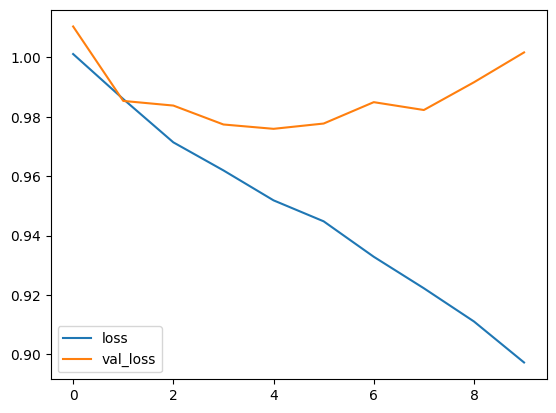

In [697]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [698]:
lstm_pred = lstm_model.predict(X_lstm_test)

455/455 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [699]:
lstm_pred = lstm_scaler_y.inverse_transform(lstm_pred)
y_lstm_test = lstm_scaler_y.inverse_transform(y_lstm_test)

In [700]:
(mean_absolute_error(y_lstm_test, lstm_pred), mean_squared_error(y_lstm_test, lstm_pred), r2_score(y_lstm_test, lstm_pred))

(np.float64(87.5004447250104),
 np.float64(11549.02766890201),
 0.03679055434188816)

In [703]:
lstm_bidirectional = Sequential([
        Input((seq_length, len(lstm_features))),
        Bidirectional(LSTM(50, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(50, return_sequences=False)),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

In [704]:
lstm_bidirectional.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [705]:
history_lstm_bi = lstm_bidirectional.fit(
        X_lstm_train, y_lstm_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_lstm_test, y_lstm_test),
        callbacks=[early_stopping],
        verbose=1
    )

Epoch 1/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.9990 - mae: 0.8153 - val_loss: 30885.2793 - val_mae: 137.4709
Epoch 2/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - loss: 0.9775 - mae: 0.8052 - val_loss: 30888.1699 - val_mae: 137.4842
Epoch 3/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 0.9745 - mae: 0.8038 - val_loss: 30885.1895 - val_mae: 137.4836
Epoch 4/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - loss: 0.9652 - mae: 0.7994 - val_loss: 30886.6074 - val_mae: 137.4867
Epoch 5/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.9440 - mae: 0.7896 - val_loss: 30871.5938 - val_mae: 137.4471
Epoch 6/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 0.9349 - mae: 0.7865 - val_loss: 30872.0469 - val_mae: 137.4461
Epoch 7/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 0.9327 - mae: 0.7844 - val_loss: 30861.3496 - val_mae: 137.4165
Epoch 8/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 0.9191 - mae: 0.7781 - val_loss: 30877.8

<Axes: >

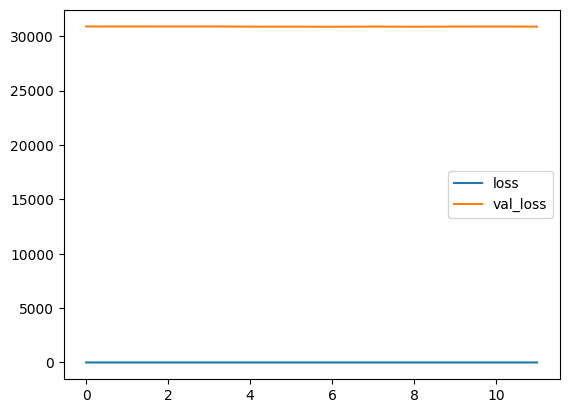

In [706]:
sns.lineplot(history_lstm_bi.history["loss"], label="loss")
sns.lineplot(history_lstm_bi.history["val_loss"], label="val_loss")

In [544]:
lstm_pred_bi = lstm_bidirectional.predict(X_lstm_test)

455/455 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [545]:
lstm_pred_bi = lstm_scaler_y.inverse_transform(lstm_pred_bi)
y_lstm_test = lstm_scaler_y.inverse_transform(y_lstm_test)

In [546]:
(mean_absolute_error(y_lstm_test, lstm_pred_bi), mean_squared_error(y_lstm_test, lstm_pred_bi), r2_score(y_lstm_test, lstm_pred_bi))

(np.float64(87.26373673324323),
 np.float64(11516.080741556503),
 0.03953838667326737)

In [651]:
lstm_stacked = Sequential([
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2), 
        Dense(1)
    ])

In [652]:
lstm_stacked.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

In [653]:
history_lstm_stacked = lstm_stacked.fit(
        X_lstm_train, y_lstm_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_lstm_test, y_lstm_test),
        callbacks=[early_stopping],
        verbose=1
    )

Epoch 1/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.6305 - mae: 0.6021 - val_loss: 0.0514 - val_mae: 0.1824
Epoch 2/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - loss: 0.0901 - mae: 0.2370 - val_loss: 0.0483 - val_mae: 0.1779
Epoch 3/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 0.0518 - mae: 0.1829 - val_loss: 0.0483 - val_mae: 0.1792
Epoch 4/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0485 - mae: 0.1790 - val_loss: 0.0491 - val_mae: 0.1801
Epoch 5/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - loss: 0.0486 - mae: 0.1797 - val_loss: 0.0487 - val_mae: 0.1800
Epoch 6/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 0.0482 - mae: 0.1791 - val_loss: 0.0487 - val_mae: 0.1794
Epoch 7/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - loss: 0.0484 - mae: 0.1794 - val_loss: 0.0481 - val_mae: 0.1766
Epoch 8/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 51s 56ms/step - loss: 0.0474 - mae: 0.1777 - val_loss: 0.0477 - val_mae: 0.1795
Epoch 9/50
910/910 ━━━━━━━━━━━━━━━━━━━━ 

<Axes: >

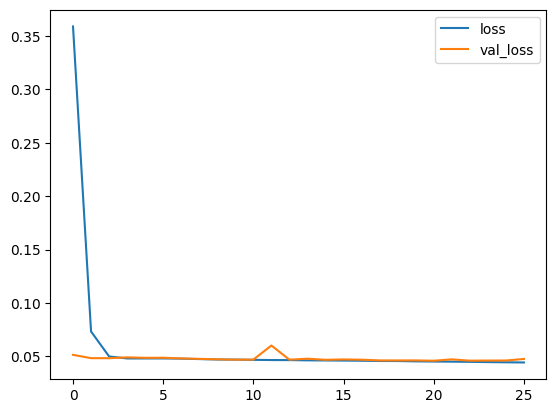

In [654]:
sns.lineplot(history_lstm_stacked.history["loss"], label="loss")
sns.lineplot(history_lstm_stacked.history["val_loss"], label="val_loss")

In [655]:
lstm_pred_stacked = lstm_stacked.predict(X_lstm_test)

455/455 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [656]:
lstm_pred_stacked = lstm_scaler_y.inverse_transform(lstm_pred_stacked)
y_lstm_test = lstm_scaler_y.inverse_transform(y_lstm_test)

In [657]:
(mean_absolute_error(y_lstm_test, lstm_pred_stacked), mean_squared_error(y_lstm_test, lstm_pred_stacked), r2_score(y_lstm_test, lstm_pred_stacked))

(np.float64(85.95821753642814),
 np.float64(11434.7830596933),
 0.04631875791539386)

In [658]:
cnn_lstm_model = Sequential([
        Input((seq_length, len(lstm_features))),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        Dropout(0.3),
        MaxPooling1D(pool_size=2),
        
        LSTM(50, return_sequences=False),
        Dropout(0.3),
        
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

In [659]:
cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [660]:
history_cnn_lstm = cnn_lstm_model.fit(
        X_lstm_train, y_lstm_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_lstm_test, y_lstm_test),
        callbacks=[early_stopping],
        verbose=1
    )

Epoch 1/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0509 - mae: 0.1819 - val_loss: 30813.1250 - val_mae: 137.1988
Epoch 2/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0477 - mae: 0.1780 - val_loss: 30813.6484 - val_mae: 137.2014
Epoch 3/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0479 - mae: 0.1787 - val_loss: 30809.8906 - val_mae: 137.1872
Epoch 4/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0477 - mae: 0.1789 - val_loss: 30804.8281 - val_mae: 137.1697
Epoch 5/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0475 - mae: 0.1780 - val_loss: 30810.3477 - val_mae: 137.1894
Epoch 6/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0478 - mae: 0.1788 - val_loss: 30812.5820 - val_mae: 137.1976
Epoch 7/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0473 - mae: 0.1774 - val_loss: 30810.7324 - val_mae: 137.1902
Epoch 8/50
1819/1819 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0472 - mae: 0.1776 - val_loss: 30811.7852 - val_mae:

<Axes: >

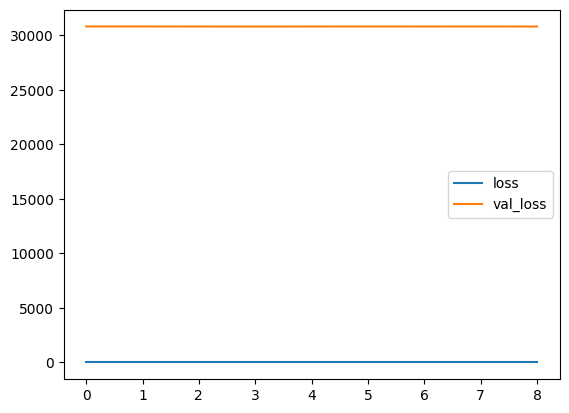

In [661]:
sns.lineplot(history_cnn_lstm.history["loss"], label="loss")
sns.lineplot(history_cnn_lstm.history["val_loss"], label="val_loss")

In [662]:
lstm_pred_cnn = lstm_stacked.predict(X_lstm_test)

455/455 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [663]:
lstm_pred_cnn = lstm_scaler_y.inverse_transform(lstm_pred_cnn)
y_lstm_test = lstm_scaler_y.inverse_transform(y_lstm_test)

In [664]:
(mean_absolute_error(y_lstm_test, lstm_pred_cnn), mean_squared_error(y_lstm_test, lstm_pred_cnn), r2_score(y_lstm_test, lstm_pred_cnn))

(np.float64(68463.8531000469),
 np.float64(7672167467.7548),
 -1.5697583966154869)